# Edge AI Anomaly Detection

## Overview

This document contains the code and the instructions for our EclipseCON 2022 Talk: "_How to Train Your Dragon and Its Friends: AI on the Edge with Eclipse Kura&trade;_"

In this example scenario we will collect the data provided by a [Raspberry Pi Sense HAT](https://www.raspberrypi.com/products/sense-hat/) using [Eclipse Kura&trade;](https://www.eclipse.org/kura/) and upload them to a [Eclipse Kapua&trade;](https://www.eclipse.org/kapua/) instance. We will then download this data and train an AI-based anomaly detector using [TensorFlow](https://www.tensorflow.org/). Finally we will deploy the trained anomaly detector model leveraging [Nvidia Triton&trade; Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) and Eclipse Kura&trade; integration.

![image1.png](imgs/img1.png)

We'll subdivide this example scenario in three main sections:
1. **Data collection**: in this section we'll discuss how to retrieve training data from the field leveraging Eclipse Kura&trade; and Eclipse Kapua&trade;
2. **Model building and training**: we'll further divide this section in three subsections:
    - *Data processing*: where we'll show how to explore our training data and manipulate them to make them suitable for training (feature selection, scaling and dataset splitting). This will provide us with the "_Preprocessing_" stage of the resulting AI data-processing pipeline
    - *Model training*: where we'll discuss how we can create a simple Autoencoder in Tensorflow Keras and how to train it. This will provide us with the "_Inference_" stage of the AI pipeline
    - *Model evaluation*: where we'll cover how can we extract the high level data from the model output and ensure the model was trained correctly. This will provide us with the "_Postprocessing_" stage of the AI pipeline
3. **Model deployment**: finally we will convert the model to make it suitable for running on Eclipse Kura&trade; and Nvidia Triton&trade; and deploy it on the edge.

---

## Data collection

### Overview

In this setup we'll leverage Eclipe Kura&trade; and Kapua&trade; for retrieving data from a [Raspberry Pi Sense HAT](https://www.raspberrypi.com/products/sense-hat/) and upload them to the cloud.

The Sense HAT is an add-on board for Raspberry Pi which provides an 8×8 RGB LED matrix, a five-button joystick and includes the following sensors:

- Gyroscope
- Accelerometer
- Magnetometer
- Temperature
- Barometric pressure
- Humidity

![image2.png](imgs/img2.png)

### Kura&trade; installation

**Requirement**: A Raspberry Pi 3/4 running the latest version of Raspberry Pi OS 64 bit.

To make everything work on the Raspberry Pi we need to use the `develop` version of the `raspberry-pi-ubuntu-20-nn` Kura installer (yes, I know we're installing the Ubuntu package on the Raspberry Pi OS but bear with me...) . You can do so by downloading the repo and [building locally](https://github.com/eclipse/kura#build-kura) or by downloading a pre-built installer from the [Kura CI artifacts](https://ci.eclipse.org/kura/).

Copy the resulting file `kura_<version>_raspberry-pi-ubuntu-20_installer-nn.deb` on the target device.

On the target device run the following commands:

```bash
sudo apt-get install -y wget apt-transport-https gnupg
```
```bash
sudo wget -O - https://packages.adoptium.net/artifactory/api/gpg/key/public | sudo apt-key add -
```
```bash
sudo echo "deb https://packages.adoptium.net/artifactory/deb $(awk -F= '/^VERSION_CODENAME/{print$2}' /etc/os-release) main" | sudo tee /etc/apt/sources.list.d/adoptium.list
```
```bash
sudo apt-get update && sudo apt-get install temurin-8-jdk chrony
```

Finally install Kura with:
```bash
sudo apt install ./kura_<version>_raspberry-pi-ubuntu-20_installer-nn.deb
```

### Cloud connection

After setting up an Eclipse Kura&trade; instance on the Raspberry Pi we'll need to connect it to an [Eclipse Kapua&trade;](https://www.eclipse.org/kapua/) instance.

![image3.png](imgs/img3.png)

An excellent tutorial on how to deploy a Kapua&trade; instance using Docker is available [in the official repository](https://github.com/eclipse/kapua/blob/develop/deployment/docker/README.md). For the purpose of this tutorial we'll assume a Kapua&trade; instance is already running and is available for connection from Kura&trade;

After setting up the Kapua&trade; instance you can refer to the [official Kura&trade; documentation](https://eclipse.github.io/kura/docs-develop/cloud-platform/kura-kapua/) for connecting the Raspberry Pi to the Kapua&trade; instance. For the remaining of this tutorial we'll assume a connection with the Kapua&trade; was correctly established.

![image4.png](imgs/img4.png)

### Data publisher

To publish the collected data on the Cloud we'll need to create a new [Cloud Publisher](https://eclipse.github.io/kura/docs-release-5.2/cloud-api/overview/#cloudpublisher) through the Kura&trade; web interface. Go to "Cloud Connections" and press "New Pub/Sub", in the example below we'll call our new publisher `KapuaSenseHatPublisher`.

![image5.png](imgs/img5.png)

To keep things clean we'll create a new topic called `SenseHat`. To do so we'll move to the `KapuaSenseHatPublisher` configuration and we'll update the `Application Topic` field to `A1/SenseHat`

![image6.png](imgs/img6.png)

### SenseHat driver

Kura&trade; provides a driver that allows to interact to a RaspberryPi SenseHat device using [Kura Driver, Asset and Wires frameworks](https://eclipse.github.io/kura/docs-develop/connect-field-devices/driver-and-assets/).

From the Kura&trade; documentation:

> Eclipse Kura introduces a model based on the concepts of Drivers and Assets to simplify the communication with the field devices attached to a gateway.
>
> A **Driver** encapsulates the communication protocol and its configuration parameters, dealing with the low-level characteristics of the field protocol. It opens, closes and performs the communication with the end field device. It also exposes field protocol specific information that can be used by upper levels of abstraction to simplify the interaction with the end devices.
>
> An **Asset** is a logical representation of a field device, described by a list of **Channels**. The Asset uses a specific Driver instance to communicate with the underlying device and it models a generic device resource as a Channel. A register in a PLC or a GATT Characteristic in a Bluetooth device are examples of Channels. In this way, each Asset has multiple Channels for reading and writing data from/to an Industrial Device.

The Kura Sense Hat driver requires a few changes on the Raspberry Pi:
- Configured SenseHat: see [SenseHat documentation](https://www.raspberrypi.com/documentation/accessories/sense-hat.html)
- I2C interface should be unlocked using `sudo raspi-config`

As others Drivers supported by Kura, it is distributed as a deployment package on the Eclipse Marketplace. It consists of two packages:
- [SenseHat Example Driver](https://marketplace.eclipse.org/content/sensehat-example-driver-eclipse-kura-4xy).
- [SenseHat Support Library](https://marketplace.eclipse.org/content/sensehat-support-library-bundle-eclipse-kura-45)

We need to install both. Complete installation instructions are available [here](https://eclipse.github.io/kura/docs-develop/connect-field-devices/sensehat-driver/).

#### Driver configuration

We now need to configure the driver to access the sensors on the SenseHat. Move to the "Driver and Assets" section of the web UI and create a new driver. We'll call it `driver-sensehat`.

![image7.png](imgs/img7.png)

Then add a new Asset (which we'll call `asset-sensehat`) to this driver and configure it as per the screenshots below. We'll need a Channel for every sensor we want to access.

![image8.png](imgs/img8.png)

![image9.png](imgs/img9.png)

Refer to the following table for the driver parameters:

| name       | type | value.type | resource                  |
|------------|------|------------|---------------------------|
| ACC_X      | READ | FLOAT      | ACCELERATION_X            |
| ACC_Y      | READ | FLOAT      | ACCELERATION_Y            |
| ACC_Z      | READ | FLOAT      | ACCELERATION_Z            |
| GYRO_X     | READ | FLOAT      | GYROSCOPE_X               |
| GYRO_Y     | READ | FLOAT      | GYROSCOPE_Y               |
| GYRO_Z     | READ | FLOAT      | GYROSCOPE_Z               |
| HUMIDITY   | READ | FLOAT      | HUMIDITY                  |
| PRESSURE   | READ | FLOAT      | PRESSURE                  |
| TEMP_HUM   | READ | FLOAT      | TEMPERATURE_FROM_HUMIDITY |
| TEMP_PRESS | READ | FLOAT      | TEMPERATURE_FROM_PRESSURE |

After correctly configuring it you should see the data in the "Data" page of the UI.

![image10.png](imgs/img10.png)

### Wire graph

Now that we have our Driver and Cloud Publisher ready we can put everything together with a [Kura Wire Graph](https://eclipse.github.io/kura/docs-develop/kura-wires/introduction/).

From Kura&trade; documentation:

> The Kura&trade; Wires feature aims to simplify the development of IoT Edge Computing Applications leveraging reusable configurable components that can be wired together and which, eventually, allows configurable cooperation between these components.
>
> In the dataflow programming model, the application logic is expressed as a directed graph (flow) where each node can have inputs, outputs, and independent processing units. There are nodes that only produce outputs and ones that only consume inputs, which usually represent the start and the end of the flow. The inner-graph nodes process the inputs and produce outputs for downstream nodes. The processing unit of a node executes independently and does not affect the execution of other nodes. Thus, the nodes are highly reusable and portable.

Move to the "Wire Graph" section of the UI. We'll need a graph with three components:
- A `Timer` which will dictate the sample rate at which we will collect data coming from the Sense Hat
- A `WireAsset` for the Sense Hat driver asset
- A `Publisher` for the Kapua publisher we created before.

The resulting Wire Graph will look like this:

![image11.png](imgs/img11.png)

#### Timer

Configure the timer such that it will poll the SenseHat each second, this can be done by setting the `simple.interval` to `1`.

![image12.png](imgs/img12.png)

#### WireAsset

Select the `driver-sensehat` when creating the WireAsset. No further configuration is needed for this component.

![image13.png](imgs/img13.png)

#### Publisher

Create a "Publisher" Wire component and select the `KapuaSensehatPublisher` from the target filter.

![image14.png](imgs/img14.png)

Don't forget to press "Apply" to start the Wire Graph!

### Collect the data

At this point you should see data coming from the Rasperry Pi from the Kapua&trade; console under the `SenseHat` topic.

![image15.png](imgs/img15.png)

You can download the `.csv` file directly from the console using the "_Export to CSV_" button.

---

## Model building and training

### Overview

We will now use the data collected in the previous section to train an artificial neural network-based Anomaly Detector of our design. To this end we will use an Autoencoder model. To understand why we choose such model we need to understand how it works. From [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder):

> An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). The encoding is validated and refined by attempting to regenerate the input from the encoding. The autoencoder learns a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore insignificant data (“noise”).

> Another application for autoencoders is **anomaly detection**. By learning to replicate the most salient features in the training data [...] the model is encouraged to learn to precisely reproduce the most frequently observed characteristics. When facing anomalies, the model should worsen its reconstruction performance. In most cases, only data with normal instances are used to train the autoencoder; in others, the frequency of anomalies is small compared to the observation set so that its contribution to the learned representation could be ignored. **After training, the autoencoder will accurately reconstruct "normal" data, while failing to do so with unfamiliar anomalous data**. Reconstruction error (the error between the original data and its low dimensional reconstruction) is used as an anomaly score to detect anomalies

In simple terms: 
- The Autoencoder is a artificial neural network model that learns how to reconstruct the input data at the output. 
- If trained on "normal" data, it learns to recontruct **only normal data** and fails to reconstruct anomalies.
- We can detect anomalies by computing the reconstruction error of the Autoencoder. If the error is above a certain threshold (which we will decide) the input sample is an anomaly.

Why did we choose this approach over others?
- The Autoencoder falls in the "[Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning)" category: it doesn't need labeled data to be trained i.e. we don't need to go through all the dataset and manually label the samples as "normal" or "anomaly" ([Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning)).
- Simpler data collection: we just need to provide it with the "normal" data. We don't need to artificially generate anomalies to train it on them.

### Data Processing

We can now work on our `.csv` file downloaded from Kapua. For demonstration purposes an already available dataset is provided within this repository.

If you're running this notebook through Google Colab you'll need to download the dataset running the cell below:

In [1]:
!wget https://raw.githubusercontent.com/mattdibi/eclipsecon-edgeAI-talk/master/notebook/train-data-raw.csv

--2022-10-07 15:16:58--  https://raw.githubusercontent.com/mattdibi/eclipsecon-edgeAI-talk/master/notebook/train-data-raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13288126 (13M) [text/plain]
Saving to: ‘train-data-raw.csv.1’

train-data-raw.csv. 100%[===================>]  12,67M  4,52MB/s    in 2,8s    

2022-10-07 15:17:02 (4,52 MB/s) - ‘train-data-raw.csv.1’ saved [13288126/13288126]



In [2]:
!ls *.csv

train-data-raw.csv


Let's start taking a look at the content of this dataset, we'll use [pandas](https://pandas.pydata.org/) (Python Data Analysis library) for this.

In [3]:
import pandas as pd

raw_data = pd.read_csv("./train-data-raw.csv")

raw_data.head()

,ID,TIMESTAMP,MAGNET_X,TEMP_HUM_timestamp,MAGNET_Z,MAGNET_Y,ACC_Y,ACC_X,GYRO_Y_timestamp,ACC_Z,...,PRESSURE_timestamp,MAGNET_X_timestamp,ACC_X_timestamp,GYRO_Z_timestamp,HUMIDITY_timestamp,assetName,ACC_Z_timestamp,GYRO_X,GYRO_Y,GYRO_Z
0,1,1645778791786,-2.680372,1645778791413,5.036951,8.646852,0.004364,0.080122,1645778791413,0.984048,...,1645778791413,1645778791413,1645778791413,1645778791413,1645778791413,asset-sensehat,1645778791413,0.053243,0.028920,0.036950
1,2,1645778792381,-3.110756,1645778792378,5.952562,10.521458,0.005091,0.080122,1645778792378,0.992090,...,1645778792378,1645778792378,1645778792378,1645778792378,1645778792378,asset-sensehat,1645778792378,-0.051105,-0.028920,-0.037256
2,3,1645778793412,-3.482263,1645778793408,6.719675,11.944528,0.005334,0.080122,1645778793408,0.986729,...,1645778793408,1645778793408,1645778793408,1645778793408,1645778793408,asset-sensehat,1645778793408,-0.025253,0.025560,0.038478
3,4,1645778794411,-3.813552,1645778794407,7.375115,13.093461,0.006061,0.080122,1645778794407,0.990384,...,1645778794407,1645778794407,1645778794407,1645778794407,1645778794407,asset-sensehat,1645778794407,0.100695,-0.023422,-0.037867
4,5,1645778795411,-4.050513,1645778795407,7.854155,14.029530,0.004849,0.080607,1645778795407,0.988922,...,1645778795407,1645778795407,1645778795407,1645778795407,1645778795407,asset-sensehat,1645778795407,-0.100389,0.021895,0.038172


#### Feature selection

As you might notice there's some information in the dataset we don't care about and are not meaningful for our application:
- `ID`
- The various `timestamps`
- `assetName` which doesn't change

Then we can remove them from the dataset.

In [4]:
features = ['ACC_Y', 'ACC_X', 'ACC_Z',
            'PRESSURE', 'TEMP_PRESS', 'TEMP_HUM',
            'HUMIDITY', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']

data = raw_data[features]

data.head()

,ACC_Y,ACC_X,ACC_Z,PRESSURE,TEMP_PRESS,TEMP_HUM,HUMIDITY,GYRO_X,GYRO_Y,GYRO_Z
0,0.004364,0.080122,0.984048,992.322998,38.724998,40.330822,19.487146,0.053243,0.028920,0.036950
1,0.005091,0.080122,0.992090,992.288330,38.772915,40.385788,19.465750,-0.051105,-0.028920,-0.037256
2,0.005334,0.080122,0.986729,992.275635,38.795834,40.349144,19.572731,-0.025253,0.025560,0.038478
3,0.006061,0.080122,0.990384,992.279053,38.797916,40.330822,19.358767,0.100695,-0.023422,-0.037867
4,0.004849,0.080607,0.988922,992.333008,38.845833,40.385788,19.390862,-0.100389,0.021895,0.038172


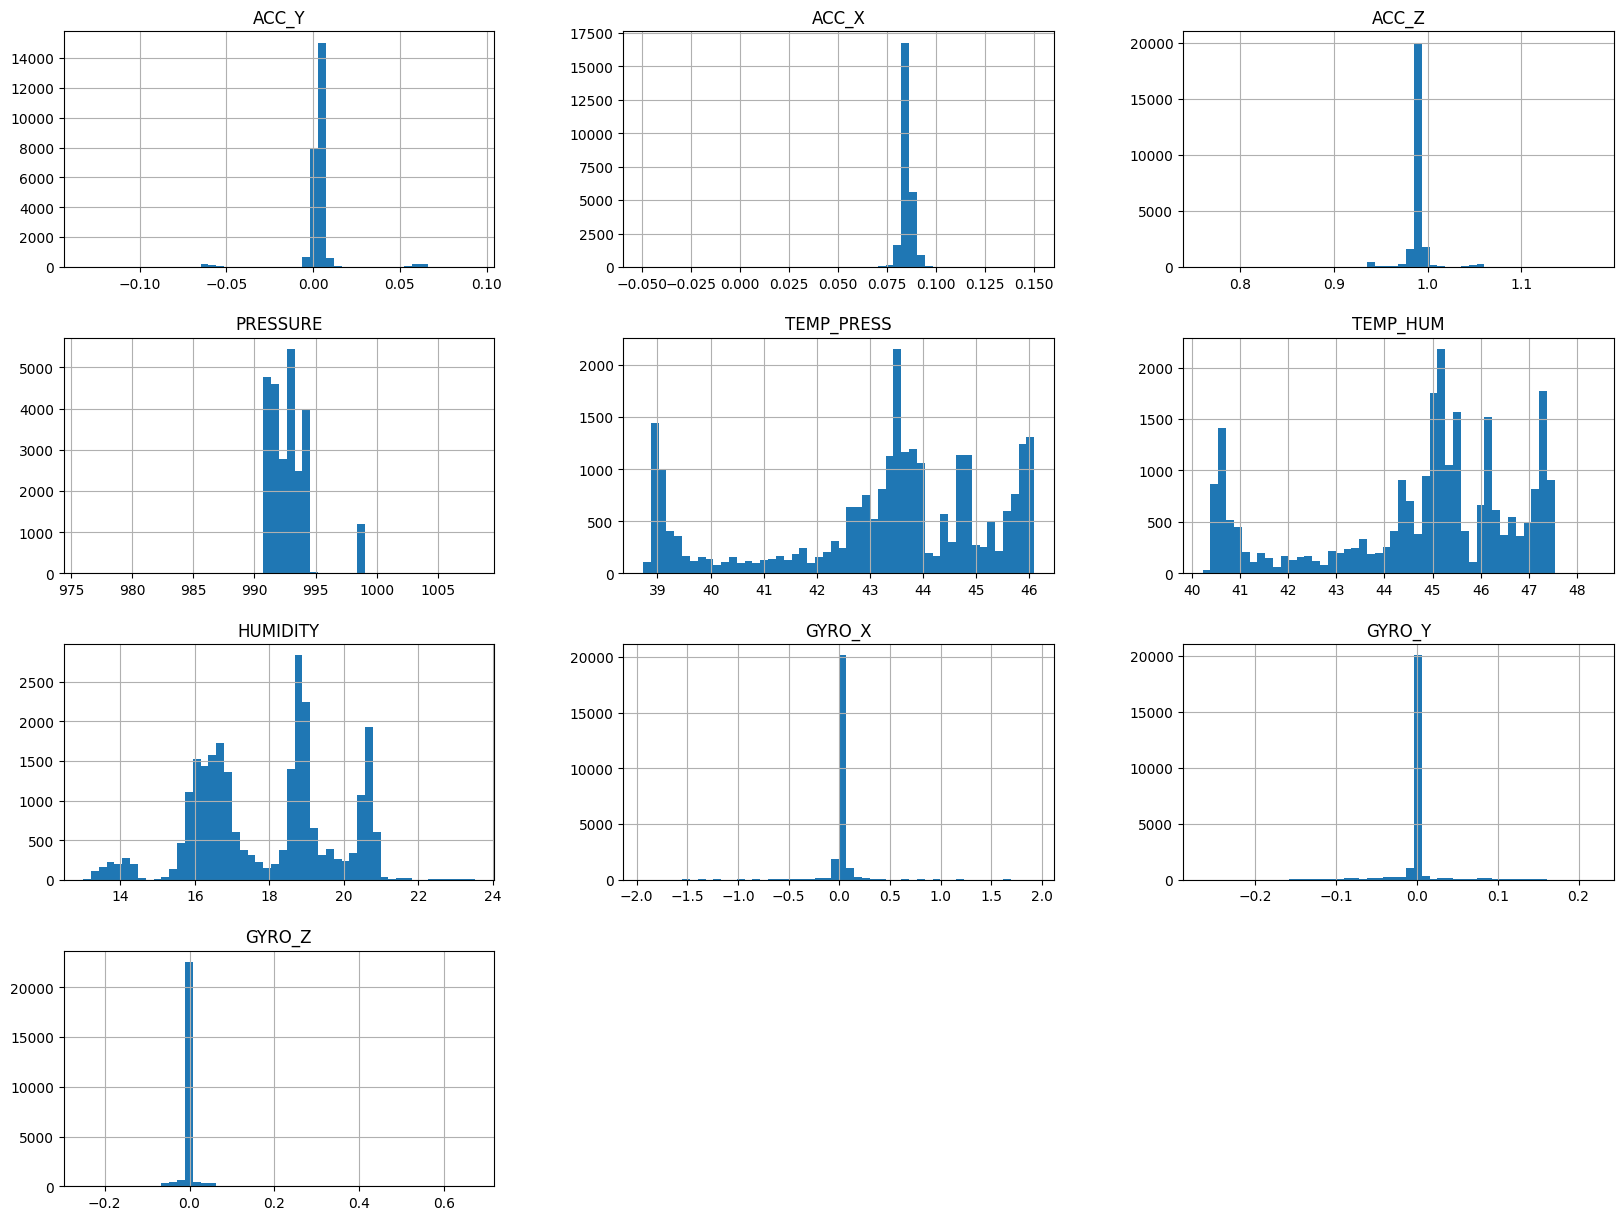

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

data.hist(bins=50, figsize=(20,15))
plt.show()

**Note**: Some of you might notice that this is a really simple dataset: some of the input data (like `GYRO_*` and `ACC_*`) do not change much over time. Such a dataset is not very challenging and a few, well-placed, thresholds might be sufficient to spot anomalous behaviour. For this tutorial we decided to keep things simple and easy to replicate. Anomalies can be simply triggered by moving the Raspberry Pi around.

Keep in mind that this approach is generic: any dataset from any appliance/connected device can be processed in the same way we're showing here. That's the magic of neural networks!

#### Feature scaling

AI models don't perform well when the input numerical attributes have very different scales. As you can see `ACC_X`, `ACC_Y` and `ACC_Z` range from 0 to 1, while the `PRESSURE` have far higher values.

There are two common ways to address this: _normalization_ and _standardization_.

_Normalization_ (a.k.a. Min-max scaling) shifts and rescales values so that they end up ranging from 0 to 1. This can be done by subtracting the min value and dividing by the max minus the min.

x' = $\frac{x - min(x)}{max(x) - min(x)}$

_Standardization_ makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance. The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) of each feature by its standard deviation.

x' = $\frac{x - avg(x)}{\sigma}$

Fortunately for us [scikit-learn](https://scikit-learn.org/stable/) library provides a function for both of them. In this case we'll use _normalization_ because it works well for this application.

In [6]:
print("Data used in the Triton preprocessor")
print("-----------Min-----------")
print(data.min())
print("-----------Max-----------")
print(data.max())
print("-------------------------")

Data used in the Triton preprocessor
-----------Min-----------
ACC_Y          -0.132551
ACC_X          -0.049693
ACC_Z           0.759847
PRESSURE      976.001709
TEMP_PRESS     38.724998
TEMP_HUM       40.220890
HUMIDITY       13.003981
GYRO_X         -1.937896
GYRO_Y         -0.265019
GYRO_Z         -0.250647
dtype: float64
-----------Max-----------
ACC_Y            0.093099
ACC_X            0.150289
ACC_Z            1.177543
PRESSURE      1007.996338
TEMP_PRESS      46.093750
TEMP_HUM        48.355824
HUMIDITY        23.506138
GYRO_X           1.923712
GYRO_Y           0.219204
GYRO_Z           0.671759
dtype: float64
-------------------------


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.to_numpy())

In [8]:
pd.DataFrame(scaled_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000,25278.000000
mean,0.603124,0.674196,0.550454,0.526446,0.605576,0.552252,0.466400,0.501160,0.545457,0.271295
std,0.049333,0.015135,0.031627,0.054050,0.288300,0.256587,0.176293,0.062908,0.067678,0.014665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.597087,0.667343,0.544924,0.481917,0.501060,0.441442,0.325637,0.501348,0.544670,0.270709
50%,0.603534,0.673413,0.551342,0.521377,0.655357,0.608108,0.511715,0.501841,0.547096,0.271685
75%,0.611055,0.680698,0.555426,0.552892,0.819339,0.734234,0.575212,0.502407,0.549386,0.272577
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Train test split

The only way to know how well a model will generalize to new data points is to try it on new data. To do so we split our data into two sets: the training set and the test set.

To do so we'll use a function from `scikit-learn`.

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test = train_test_split(scaled_data, test_size=0.3, random_state=42)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

---

### Model training

We can now leverage the [Keras](https://keras.io/) API of [Tensorflow](https://www.tensorflow.org/) for creating our Autoencoder and then train it on our dataset.

We'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input (also called the _latent-space representation_). If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.

The bottleneck consists of reducing the number of neurons for each layer of the neural network up to a certain point, and then increase the number until the original input number is reached. This will result in a hourglass shape which is typical for the Autoencoders.

![image16.png](imgs/img16.png)

#### Build the Autoencoder model

In this example we'll use a basic fully-connected autoencoder but keep in mind that autoencoders can be built with different classes of neural network (i.e. Convolutional Neural Networks, Recurrent Neural Networks etc).

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Avoid AVX2 error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_model(input_dim):
    # The encoder will consist of a number of dense layers that decrease in size
    # as we taper down towards the bottleneck of the network, the latent space
    input_data = Input(shape=(input_dim,), name='INPUT0')

    # hidden layers
    encoder = Dense(9, activation='tanh', name='encoder_1')(input_data)
    encoder = Dropout(.15)(encoder)
    encoder = Dense(6, activation='tanh', name='encoder_2')(encoder)
    encoder = Dropout(.15)(encoder)

    # bottleneck layer
    latent_encoding = Dense(3, activation='linear', name='latent_encoding')(encoder)

    # The decoder network is a mirror image of the encoder network
    decoder = Dense(6, activation='tanh', name='decoder_1')(latent_encoding)
    decoder = Dropout(.15)(decoder)
    decoder = Dense(9, activation='tanh', name='decoder_2')(decoder)
    decoder = Dropout(.15)(decoder)

    # The output is the same dimension as the input data we are reconstructing
    reconstructed_data = Dense(input_dim, activation='linear', name='OUTPUT0')(decoder)

    autoencoder_model = Model(input_data, reconstructed_data)

    return autoencoder_model

In [11]:
autoencoder_model = create_model(len(features))
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT0 (InputLayer)         [(None, 10)]              0         
                                                                 
 encoder_1 (Dense)           (None, 9)                 99        
                                                                 
 dropout (Dropout)           (None, 9)                 0         
                                                                 
 encoder_2 (Dense)           (None, 6)                 60        
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 latent_encoding (Dense)     (None, 3)                 21        
                                                                 
 decoder_1 (Dense)           (None, 6)                 24    

![image17.png](imgs/img17.png)

#### Model training

As we already explained, the autoencoder is a  type of artificial neural network used to learn efficient codings of unlabeled data. We'll use that to reconstruct the input at the output. To train an autoencoder we don’t need to do anything fancy, just throw the raw input data at it. Autoencoders are considered an unsupervised learning technique since they don’t need explicit labels to train on but to be more precise they are self-supervised because they generate their own labels from the training data.

To train our neural network we need to have a performance metric to measure how well it is learning to reconstruct the data i.e. our _loss function_. The loss function in our example, which we need to minimize during our training, is the error between the _input data_ and the _data reconstructed by the autoencoder_. We'll use the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error).

MSE = $\frac{1}{n}\sum_{i=1}^{n}{(Y_i - Y'_i)^2}$

Where:
- $n$: is the number of features (10 in our example)
- $Y_i$: is the original data point i.e. the input of the autoencoder 
- $Y'_i$: is the reconstructed data point i.e. the output of the autoencoder

Before starting the training we need to set the [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Hyperparameters are parameters whose values control the learning process and determine the values of model parameters that a learning algorithm ends up learning. These are the `learning_rate`, `max_epochs`, `optimizer` and the `batch_size` you see in the code snippet below. You may ask yourself how to set them, it all comes down to trial and error. Try tweaking them below and see how they affect the learning process...

A good explaination of their meaning can be found in the [Keras documentation](https://keras.io/api/models/model_training_apis/).

In [12]:
from tensorflow.keras import optimizers

batch_size = 32
max_epochs = 15
learning_rate = .0001

opt = optimizers.Adam(learning_rate=learning_rate)
autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
train_history = autoencoder_model.fit(x_train, x_train,
                      shuffle=True,
                      epochs=max_epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test))

Epoch 1/15
553/553 [==============================] - 1s 2ms/step - loss: 0.2466 - accuracy: 0.0397 - val_loss: 0.1072 - val_accuracy: 2.6371e-04
Epoch 2/15
553/553 [==============================] - 1s 1ms/step - loss: 0.1073 - accuracy: 0.1230 - val_loss: 0.0430 - val_accuracy: 0.3165
Epoch 3/15
553/553 [==============================] - 1s 1ms/step - loss: 0.0628 - accuracy: 0.1963 - val_loss: 0.0254 - val_accuracy: 0.3178
Epoch 4/15
553/553 [==============================] - 1s 1ms/step - loss: 0.0461 - accuracy: 0.2096 - val_loss: 0.0211 - val_accuracy: 0.3212
Epoch 5/15
553/553 [==============================] - 1s 1ms/step - loss: 0.0378 - accuracy: 0.2257 - val_loss: 0.0185 - val_accuracy: 0.3227
Epoch 6/15
553/553 [==============================] - 1s 1ms/step - loss: 0.0321 - accuracy: 0.2538 - val_loss: 0.0164 - val_accuracy: 0.3227
Epoch 7/15
553/553 [==============================] - 1s 1ms/step - loss: 0.0274 - accuracy: 0.2865 - val_loss: 0.0146 - val_accuracy: 0.3285
Ep

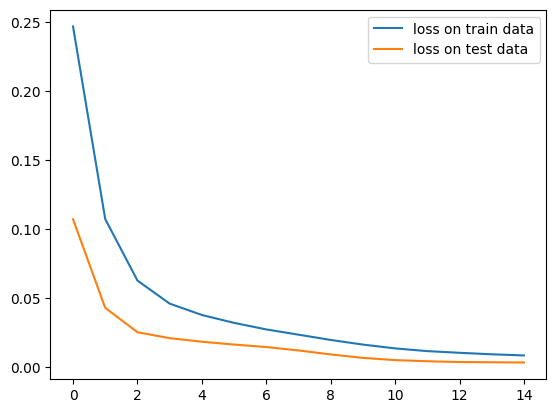

In [13]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on test data'])

Here we can see the loss for the training set and the test set on the epochs.

Some of you might notice that this graph is somewhat unexpected. Why the validation loss is lower than the train loss? This is the effect of the regularization: regularization terms and dropout layer are affecting the network during training. A good writeup of this effect can be found [here](https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e).

As an excercise try and compute the average MSE on the training set and the test set. You'll find that the MSE is lower in the training set!

We can now save the model on disk as we'll use this later.

In [ ]:
autoencoder_model.save("./saved_model/autoencoder")

In [ ]:
!ls ./saved_model/autoencoder

---

### Model evaluation

We now have a model that reconstruct the input at the output... doesn't sounds really useful right?

Let's see it in action. Let's take a sample from the test set and run it through our autoencoder.

In [14]:
input_sample = x_test[3:4].copy() # Deep copy

reconstructed_sample = autoencoder_model.predict(input_sample)

print(input_sample)
print(reconstructed_sample)

1/1 [==============================] - 0s 100ms/step
[[0.603534   0.6770555  0.54900813 0.5327966  0.6680801  0.6171171
  0.5198642  0.50135666 0.54716927 0.2718224 ]]
[[0.5966772  0.66877955 0.54494107 0.5189046  0.6275078  0.57187307
  0.45011348 0.49867785 0.5385958  0.27126077]]


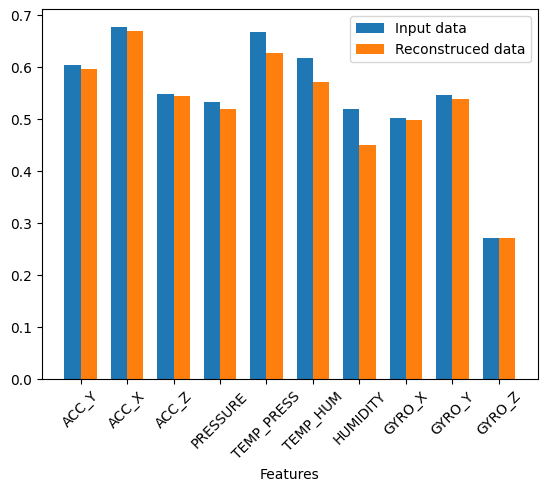

In [15]:
import matplotlib.pyplot as plt

index = np.arange(10)
bar_width = 0.35

figure, ax = plt.subplots()

inbar = ax.bar(index, input_sample[0], bar_width, label="Input data")
recbar = ax.bar(index+bar_width, reconstructed_sample[0], bar_width, label="Reconstruced data")

ax.set_xlabel('Features')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features, rotation = 45)
ax.legend()

As we can see from the graph above it reconstructed the input fairly well. It is not perfect since the Autoencoder is lossy but it is good enough

What happens if we manipulate this sample in a way the autoencoder doesn't expect (i.e. we introduce an **anomaly**)?

Let's try and set the `ACC_Z` to a value the autoencoder has never seen before.

In [16]:
input_anomaly = input_sample.copy() # Deep copy

input_anomaly[0][2] = 0.15

reconstructed_anomaly = autoencoder_model.predict(input_anomaly)

print(input_anomaly)
print(reconstructed_anomaly)

1/1 [==============================] - 0s 20ms/step
[[0.603534   0.6770555  0.15       0.5327966  0.6680801  0.6171171
  0.5198642  0.50135666 0.54716927 0.2718224 ]]
[[0.6044929  0.6716235  0.53711015 0.5149716  0.61000896 0.5421204
  0.49940306 0.529299   0.543179   0.27389684]]


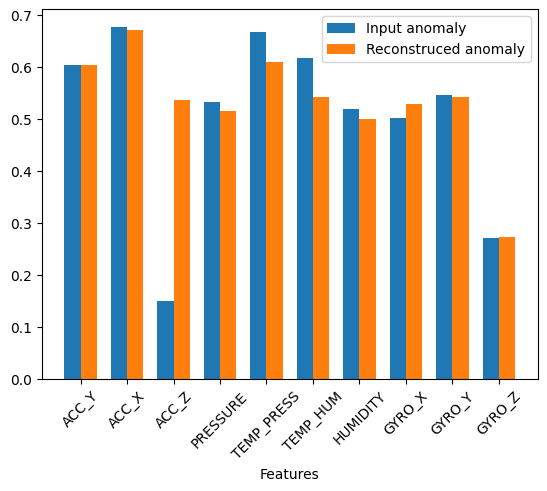

In [17]:
figure, ax = plt.subplots()

inbar = ax.bar(index, input_anomaly[0], bar_width, label="Input anomaly")
recbar = ax.bar(index+bar_width, reconstructed_anomaly[0], bar_width, label="Reconstruced anomaly")

ax.set_xlabel('Features')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features, rotation = 45)
ax.legend()

The autoencoder fails to reconstruct the data it received at the input. This means that the reconstruction error is very high.

In [18]:
from sklearn.metrics import mean_squared_error

print("Anomaly %f"% mean_squared_error(input_anomaly[0], reconstructed_anomaly[0]))
print("Normal  %f"% mean_squared_error(input_sample[0], reconstructed_sample[0]))

Anomaly 0.016042
Normal  0.000896


**It's working as expected!**

We now need to decide when to trigger an alarm (i.e. classify an input sample as anomalous) from this reconstruction error. In other words we need to decide our threshold.

There are multiple ways to set this value, in this example we'll use the [Z-Score](https://en.wikipedia.org/wiki/Standard_score).

From Wikipedia:
> In statistics, the standard score is the number of standard deviations by which the value of a raw score (i.e., an observed value or data point) is above or below the mean value of what is being observed or measured.[...]
>
> It is calculated by subtracting the population mean from an individual raw score and then dividing the difference by the population standard deviation.

We'll consider a sample an anomaly if the Reconstruction Error Z-Score is not in the range \[-2, +2\]. This means that if the reconstruction error for a sample is more than 2 standard deviation away from the average reconstruction error computed on the test set, the sample is an anomaly. This choice is arbirtary, we can control the sensitivity of the detector by changing this range.

In [19]:
x_test_recon = autoencoder_model.predict(x_test)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)  # MSE

reconstruction_scores_pd = pd.DataFrame({'recon_score': reconstruction_scores})
print(reconstruction_scores_pd.describe())

237/237 [==============================] - 0s 767us/step
       recon_score
count  7584.000000
mean      0.003471
std       0.005403
min       0.000113
25%       0.000985
50%       0.001554
75%       0.002603
max       0.081265


In [20]:
def z_score(mse_sample):
    return (mse_sample - reconstruction_scores_pd.mean())/reconstruction_scores_pd.std()

In [21]:
mse_anomaly = mean_squared_error(input_anomaly[0], reconstructed_anomaly[0])
mse_normal = mean_squared_error(input_sample[0], reconstructed_sample[0])

z_score_anomaly = z_score(mse_anomaly)
z_score_normal = z_score(mse_normal)

print("Anomaly Z-score %f"% z_score_anomaly)
print("Normal Z-score %f"% z_score_normal)

Anomaly Z-score 2.326803
Normal Z-score -0.476539


We now have our anomaly detector... let's see how we can deploy it on our Kura&trade;-powered edge device.

---

## Model deployment

To deploy our model on the target device we'll leverage Kura&trade;'s newly added [Nvidia&trade; Triton Inferece Server](https://developer.nvidia.com/nvidia-triton-inference-server) integration.

![image18.png](imgs/img18.png)

The Nvidia™ Triton Inference Server is an open-source inference service software that enables the user to deploy trained AI models from any framework on GPU or CPU infrastructure. It supports all major frameworks like TensorFlow, TensorRT, PyTorch, ONNX Runtime, and even custom framework backend. With specific backends, it is also possible to run Python scripts, mainly for pre-and post-processing purposes, and exploit the DALI building block for optimized operations.

For installation refer to the official [Kura&trade;](https://eclipse.github.io/kura/docs-develop/core-services/nvidia-triton-server-inference-engine/#nvidiatm-triton-server-installation) and [Triton documentation](https://github.com/triton-inference-server/server/tree/main/docs#installation). For the rest of this tutorial we'll assume a Triton container is available on the target device. It can be simply installed with:

```bash
docker pull nvcr.io/nvidia/tritonserver:22.07-tf2-python-py3
```

We'll also need to install Kura&trade;'s Triton bundles:
- [Triton Server Component](https://marketplace.eclipse.org/content/triton-server-component-eclipse-kura-5): for Kura-Triton integration
- [AI Wire Component](https://marketplace.eclipse.org/content/ai-wire-component-eclipse-kura-5): for making the Triton Inference Server available through the Kura Wires as a Wire component.

### Model conversion

The first step in using Triton to serve your models is to place one or more models into a [model repository](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md) i.e. a folder were the model are available for Triton to load. Depending on the type of the model and on what Triton capabilities you want to enable for the model, you may need to create a [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md) for the model. This configuration is a protobuf containing informations about runtime configuration and input/output shape accepted by the model.

For our autoencoder model we'll need three "models":
- A **Preprocessor** for performing the operations described in the ["Data processing"](#Data-Processing) section (Wire envelop translation, feature selection and scaling)
- The **Autoencoder** model we exported in the ["Model training"](#Model-training) section
- A **Postprocessor** for performing the operations described in the ["Model evaluation"](#Model-evaluation) section (Reconstruction error computation)

To simplify the handling of these models and improve inference performance, we'll use an advanced feature of Triton wich is an [Ensemble Model](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/architecture.md#ensemble-models). From Triton official documentation:

> An ensemble model represents a pipeline of one or more models and the connection of input and output tensors between those models. Ensemble models are intended to be used to encapsulate a procedure that involves multiple models, such as "data preprocessing -> inference -> data postprocessing". Using ensemble models for this purpose can avoid the overhead of transferring intermediate tensors and minimize the number of requests that must be sent to Triton.

#### Autoencoder

As seen in the ["Model training"](#Model-training) section, our model is available as a [Tensorflow _SavedModel_](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md#tensorflow-models) which can be simply loaded by the Triton [Tensorflow backend](https://github.com/triton-inference-server/tensorflow_backend). We just need to configure it properly.

We'll start by creating the following folder structure

```
tf_autoencoder_fp32
├── 1
│   └── model.savedmodel
│       ├── assets
│       ├── keras_metadata.pb
│       ├── saved_model.pb
│       └── variables
│           ├── variables.data-00000-of-00001
│           └── variables.index
└── config.pbtxt
```

This can be done by copying the model we saved in the Model Training section:

In [ ]:
!rm -rf ./tf_autoencoder_fp32/ && mkdir -p ./tf_autoencoder_fp32/1

In [ ]:
!ls

In [ ]:
cp -r ./saved_model/autoencoder tf_autoencoder_fp32/1/model.savedmodel

In [ ]:
!find tf_autoencoder_fp32 -maxdepth 3 -ls # or !tree tf_autoencoder_fp32

Now comes the hard part: we need to provide the [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md) (i.e. the `config.pbtxt` file). In the case of the autoencoder is pretty simple:

```protobuf
name: "tf_autoencoder_fp32"
backend: "tensorflow"
max_batch_size: 0
input [
    {
    name: "INPUT0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
    }
]
output [
    {
    name: "OUTPUT0"
    data_type: TYPE_FP32
    dims: [ -1, 10 ]
    }
]
version_policy: { all { }}
instance_group [{ kind: KIND_CPU }]
```

Each model `input` and `output` must specify the `name`, `data_type` and `dims`. We already know all of these:
- `name`: corresponds to the layer name we've seen in the Model Training section. `INPUT0` for the input and `OUTPUT0` for the output.
- `data_type`: will be float since we didn't perform any quantization
- `dims`: is the shape of the in/out tensor. In this case it will correspond to an array with the same length as the number of features.

Other interesting parameters of this configuration are:
- `backend`: where we set the backend for the model. In this case it will be the Tensorflow backend
- `name`: the name of the model that must correspond to the name of the folder
- `instance_group`: where we set where we want the model to run. In this case we'll use the CPU since we're on a Raspberry Pi but keep in mind that Triton support multiple accelerators.

for a deep dive into the model configuration parameter take a look at the [official documentation](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md).

#### Preprocessor

As discussed in the ["Data processing"](#Data-Processing) section, before providing the incoming data to the autoencoder, we need to perform feature selection and scaling. In addition to these responsibilites, the Preprocessor will need to perform a sort of serialization of the data to comply to the input shape accepted by the Autoencoder. This is due to how Kura manages the data running on Wires. More details can be found [here](https://eclipse.github.io/kura/docs-develop/kura-wires/single-port-wire-components/ai-wire-component/#models-input-and-output-formats).

To perform all of this we'll use the [Python backend](https://github.com/triton-inference-server/python_backend) available in Triton.

As described in the previous section we will need to provide the following folder structure:

```
preprocessor
├── 1
│   └── model.py
└── config.pbtxt
```

##### Preprocessor Configuration

As discussed in the [official Kura documentation](https://eclipse.github.io/kura/docs-develop/kura-wires/single-port-wire-components/ai-wire-component/#models-input-and-output-formats):

> The AI wire component takes a WireEnvelope as an input, it processes its records and feeds them to the specified preprocessing or inference model.
>
> ...
>
> The models that manage the input and the output must expect a list of inputs such that:
> - each input corresponds to an entry of the `WireRecord` properties
> - the entry key will become the input name (e.g. in the case of an asset, the channel name becomes the tensor name)
> - input shape will be `[1]`

Therefore for our `input` we'll have that each name corresponds to the names we've seen in the Data Collection section. The `output` needs to correspond to the input accepted by the model (i.e. `INPUT0`).

```protobuf
name: "preprocessor"
backend: "python"

input [
  {
    name: "ACC_X"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
input [
  {
    name: "ACC_Y"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
 ...
input [
  {
    name: "TEMP_PRESS"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "INPUT0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
  }
]
instance_group [{ kind: KIND_CPU }]
```

##### Preprocessor Model

As we've seen in the Data Processing section the Preprocessor is responsible for scaling the input features and serializing them in the tensor shape expected by the Autoencoder model.

This can be done with the following python script:

```python
import numpy as np
import json

import triton_python_backend_utils as pb_utils


class TritonPythonModel:

    def initialize(self, args):
        self.model_config = model_config = json.loads(args['model_config'])

        output0_config = pb_utils.get_output_config_by_name(
            model_config, "INPUT0")

        self.output0_dtype = pb_utils.triton_string_to_numpy(
            output0_config['data_type'])

    def execute(self, requests):
        output0_dtype = self.output0_dtype

        responses = []

        for request in requests:
            acc_x      = pb_utils.get_input_tensor_by_name(request, "ACC_X").as_numpy()
            acc_y      = pb_utils.get_input_tensor_by_name(request, "ACC_Y").as_numpy()
            acc_z      = pb_utils.get_input_tensor_by_name(request, "ACC_Z").as_numpy()
            gyro_x     = pb_utils.get_input_tensor_by_name(request, "GYRO_X").as_numpy()
            gyro_y     = pb_utils.get_input_tensor_by_name(request, "GYRO_Y").as_numpy()
            gyro_z     = pb_utils.get_input_tensor_by_name(request, "GYRO_Z").as_numpy()
            humidity   = pb_utils.get_input_tensor_by_name(request, "HUMIDITY").as_numpy()
            pressure   = pb_utils.get_input_tensor_by_name(request, "PRESSURE").as_numpy()
            temp_hum   = pb_utils.get_input_tensor_by_name(request, "TEMP_HUM").as_numpy()
            temp_press = pb_utils.get_input_tensor_by_name(request, "TEMP_PRESS").as_numpy()

            out_0 = np.array([acc_y, acc_x, acc_z, pressure, temp_press, temp_hum, humidity, gyro_x, gyro_y, gyro_z]).transpose()

            #                  ACC_Y     ACC_X     ACC_Z    PRESSURE   TEMP_PRESS   TEMP_HUM   HUMIDITY    GYRO_X    GYRO_Y    GYRO_Z
            min = np.array([-0.132551, -0.049693, 0.759847, 976.001709, 38.724998, 40.220890, 13.003981, -1.937896, -0.265019, -0.250647])
            max = np.array([ 0.093099, 0.150289, 1.177543, 1007.996338, 46.093750, 48.355824, 23.506138, 1.923712, 0.219204, 0.671759])

            # MinMax scaling
            out_0_scaled = (out_0 - min)/(max - min)

            # Create output tensor
            out_tensor_0 = pb_utils.Tensor("INPUT0",
                                           out_0_scaled.astype(output0_dtype))

            inference_response = pb_utils.InferenceResponse(
                output_tensors=[out_tensor_0])
            responses.append(inference_response)

        return responses
```

Here there are two important things to note:
- The template we're using is taken from the Triton documentation and can be found [here](https://github.com/triton-inference-server/python_backend/blob/main/examples/add_sub/model.py).
- The MinMax scaling **must be the same we used in our training**. For illustration purposes we wrote the `min` and `max` arrays we found in the Data Processing section but we could have serialized the `MinMaxScaler` using [`pickle`](https://docs.python.org/3/library/pickle.html) instead.

#### Postprocessor

As discussed in the ["Data processing"](#Data-Processing) section, to perform the anomaly detection step we need to compute the Mean Squared Error between the recontructed data and the actual input data. Due to this the configuration of the Postprocessor model will be somewhat more complicated than before: in addition to the output of the Autoencoder model we will need the output of the Preprocessor model.

To perform all of this we'll use the [Python backend](https://github.com/triton-inference-server/python_backend) again.

As described in the previous section we will need to provide the following folder structure:

```
postprocessor
├── 1
│   └── model.py
└── config.pbtxt
```

##### Postprocessor Configuration

```protobuf
name: "postprocessor"
backend: "python"

input [
  {
    name: "RECONSTR0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
  }
]
input [
  {
    name: "ORIG0"
    data_type: TYPE_FP32
    dims: [ 1, 10 ]
  }
]
output [
  {
    name: "ANOMALY_SCORE0"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "ANOMALY0"
    data_type: TYPE_BOOL
    dims: [ 1 ]
  }
]
instance_group [{ kind: KIND_CPU }]
```

As we can see we have two inputs and two outputs:
- The first input tensor is the reconstruction performed by the autoencoder model
- The second input tensor is the original data (already scaled and serialized by the Preprocessor model)
- The first output is the anomaly score i.e. the reconstruction error between the original and the reconstructed data.
- The second output is a boolean representing whether the data constitute an anomaly or not

Let's see how this is computed by the Python model.

##### Postprocessor Model

```python
import numpy as np
import json

import triton_python_backend_utils as pb_utils

def z_score(mse):
    return (mse - MEAN_MSE)/STD_MSE


class TritonPythonModel:

    def initialize(self, args):
        self.model_config = model_config = json.loads(args['model_config'])

        output0_config = pb_utils.get_output_config_by_name(
            model_config, "ANOMALY_SCORE0")
        output1_config = pb_utils.get_output_config_by_name(
            model_config, "ANOMALY0")

        self.output0_dtype = pb_utils.triton_string_to_numpy(
            output0_config['data_type'])
        self.output1_dtype = pb_utils.triton_string_to_numpy(
            output1_config['data_type'])

    def execute(self, requests):
        output0_dtype = self.output0_dtype
        output1_dtype = self.output1_dtype

        responses = []

        for request in requests:
            # Get input
            x_recon = pb_utils.get_input_tensor_by_name(request, "RECONSTR0").as_numpy()
            x_orig = pb_utils.get_input_tensor_by_name(request, "ORIG0").as_numpy()

            # Get Mean square error between reconstructed input and original input
            reconstruction_score = np.mean((x_orig - x_recon)**2, axis=1)
            
            # Z-Score of Mean square error must be inside [-2; 2]
            anomaly = np.array([z_score(reconstruction_score) < -2.0 or z_score(reconstruction_score) > 2.0])

            # Create output tensors
            out_tensor_0 = pb_utils.Tensor("ANOMALY_SCORE0",
                                           reconstruction_score.astype(output0_dtype))
            out_tensor_1 = pb_utils.Tensor("ANOMALY0",
                                           anomaly.astype(output1_dtype))

            inference_response = pb_utils.InferenceResponse(
                output_tensors=[out_tensor_0, out_tensor_1])
            responses.append(inference_response)

        return responses
```

As you can see the script is simple:
- It gets the input tensors
- It computes the Mean Squared Error between the inputs (which is what we called the reconstruction error)
- It computes the Z-Score of the MSE computed for the current sample and flags it as an anomaly if it is farther than 2 standard deviations away from the average MSE.

**Note**: `MEAN_MSE` and `STD_MSE` are the mean value and the standard deviation of the Mean Squared Error computed on the test set and correspond to the `reconstruction_scores_pd.mean()` and `reconstruction_scores_pd.std()` we used in the previous section. We didn't set them as they change for every training performed on the Autoencoder. Be sure to set it to their proper values before trying this model on the Triton server!

### Ensemble model

To make things easier for ourselves and improve performance we'll consolidate the AI pipeline into an [Ensemble Model](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/architecture.md#ensemble-models).

We will need to provide the following folder structure:

```
ensemble_pipeline
├── 1
└── config.pbtxt
```

Note that the `1` folder is **empty**. The ensemble model essentially describe *how to connect the models that belong to the processing pipeline*.

Therefore we'll need to focus on the configuration only.

```protobuf
name: "ensemble_pipeline"
platform: "ensemble"
max_batch_size: 0
input [
  {
    name: "ACC_X"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
input [
  {
    name: "ACC_Y"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
 ...
input [
  {
    name: "TEMP_PRESS"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "ANOMALY_SCORE0"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }
]
output [
  {
    name: "ANOMALY0"
    data_type: TYPE_BOOL
    dims: [ 1 ]
  }
]
ensemble_scheduling {
  step [
    {
      model_name: "preprocessor"
      model_version: -1
      input_map{
          key: "ACC_X"
          value: "ACC_X"
      }
      input_map{
          key: "ACC_Y"
          value: "ACC_Y"
      }
       ...
      input_map{
          key: "TEMP_PRESS"
          value: "TEMP_PRESS"
      }
      output_map {
        key: "INPUT0"
        value: "preprocess_out"
      }
    },
    {
      model_name: "tf_autoencoder_fp32"
      model_version: -1
      input_map {
        key: "INPUT0"
        value: "preprocess_out"
      }
      output_map {
        key: "OUTPUT0"
        value: "autoencoder_output"
      }
    },
    {
      model_name: "postprocessor"
      model_version: -1
      input_map {
        key: "RECONSTR0"
        value: "autoencoder_output"
      }
      input_map {
        key: "ORIG0"
        value: "preprocess_out"
      }
      output_map {
        key: "ANOMALY_SCORE0"
        value: "ANOMALY_SCORE0"
      }
      output_map {
        key: "ANOMALY0"
        value: "ANOMALY0"
      }
    }
  ]
}
```

The configuration is split in two main parts:
- The first is the usual configuration we've seen before: we describe what are the input and the output of our model. In this case the input will correspond to the input of the first model of the pipeline (the Preprocessor) and the output to the output of the last model of the pipeline (the Postprocessor)
- The second part describe how to map the input/output of the models within the pipeline

To better visualize the configuration we can look at the graph below.

![image19.png](imgs/img19.png)

#### Conversion results

At this point we should have a folder structure that looks like this:

```
models
├── ensemble_pipeline
│   ├── 1
│   └── config.pbtxt
├── postprocessor
│   ├── 1
│   │   └── model.py
│   └── config.pbtxt
├── preprocessor
│   ├── 1
│   │   └── model.py
│   └── config.pbtxt
└── tf_autoencoder_fp32
    ├── 1
    │   └── model.savedmodel
    │       ├── assets
    │       ├── keras_metadata.pb
    │       ├── saved_model.pb
    │       └── variables
    │           ├── variables.data-00000-of-00001
    │           └── variables.index
    └── config.pbtxt
```

### Kura Deployment

We can now move our pipeline to the target device for inference on the edge.

We want to perform anomaly detection in real time, directly within the edge device, using the same data we used to collect for our training.

![image20.png](imgs/img20.png)

#### Triton component configuration

To do so we need to copy the `models` folder on the target device. For this example we'll use the `/home/pi/models` path.

We can now move to the Kura web UI and create a new Triton Server Container Service component instance. The complete documentation can be found [here](https://eclipse.github.io/kura/docs-release-5.2/core-services/nvidia-triton-server-inference-engine/).

In this example we'll call it `TritonContainerService`.

![image21.png](imgs/img21.png)

Then we'll need to configure it to run our models. Move to the `TritonContainerService` configuration interface and set the following parameters:

- **Image name**/**Image tag**: use the name and tag of the Triton container image you installed. We're using `nvcr.io/nvidia/tritonserver:22.07-tf2-python-py3` in this example.
- **Local model repository path**: in our example is `/home/pi/models`
- **Inference Models**: we'll need to load all the models of the pipeline so: `preprocessor,postprocessor,tf_autoencoder_fp32,ensemble_pipeline`
- **Optional configuration for the local backends**: `tensorflow,version=2` since Tensorflow 2 is the only available Tensorflow backend in the Triton container image we're using.

You can leave everything else as default.

![image22.png](imgs/img22.png)

Once you press the "_Apply_" button Kura will create a new container from the Triton image we set and spin up the service with our models loaded.

```bash
pi@raspberrypi:~ $ docker ps
CONTAINER ID   IMAGE                                              COMMAND                  CREATED          STATUS          PORTS                                                                                                                             NAMES
4deae2857b6f   nvcr.io/nvidia/tritonserver:22.07-tf2-python-py3   "tritonserver --mode…"   13 seconds ago   Up 11 seconds   0.0.0.0:4000->8000/tcp, :::4000->8000/tcp, 0.0.0.0:4001->8001/tcp, :::4001->8001/tcp, 0.0.0.0:4002->8002/tcp, :::4002->8002/tcp   tritonserver-kura
```

> **Note**: if no container is created check that the "_Container Orchestration Service_" is enabled in the Kura UI. Full documentation for the service can be found [here](https://eclipse.github.io/kura/docs-release-5.2/core-services/container-orchestration-provider-usage/#starting-the-service).

> **Note**: if you see an error in the logs like "_Internal: Unable to initialize shared memory key 'triton_python_backend_shm_region_2' to requested size (67108864 bytes). If you are running Triton inside docker, use '--shm-size' flag to control the shared memory region size. Each Python backend model instance requires at least 64MBs of shared memory._", you can update the default shared memory size allocated by the Docker daemon. Go to `/etc/docker/daemon.json`, set `"default-shm-size": "200m"` and restart the Docker daemon with: `sudo systemctl restart docker`.

#### Wire Graph

Finally we can move to the "_Wire Graph_" UI and create the AI component (in the Emitters/Receiver menu) for interfacing with the Triton instance we just created. We'll call it `Triton` in this example.

![image23.png](imgs/img23.png)

We just need to change two parameter in the configuration:
- **InferenceEngineService Target Filter**: we need to select the `TritonContainerService` we created at the step above
- **inference.model.name**: Since we're using an ensemble pipeline we need only that as our inference model.

The resulting wire graph is the following:

![image24.png](imgs/img24.png)

And that's it! We should now see the anomaly detection results coming to Kapua in addition to the SenseHat data.

![image25.png](imgs/img25.png)

## Complete Example

A similar but more complete example of the feature presented in this notebook is available [in the official Kura&trade; repository](https://github.com/eclipse/kura/tree/develop/kura/examples/scenarios/org.eclipse.kura.example.ai) containing all the code and the configuration needed to make it work.

Give it a try!